In [37]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

%matplotlib inline

In [2]:
df0 = pd.read_csv('data/annual_csi_data_for_match.csv', sep=',')

# Data Cleaning

In [3]:
df0.rename(index=str, columns={"datatime": "datetime"}, inplace=True)
df0['datetime'] = pd.to_datetime(df0['datetime'])
df0.reset_index(drop = True, inplace = True)

In [4]:
# Make copy of raw import
df = df0.copy()

In [5]:
# Function for converting datetime data into just year
def dt_to_year(df):
    df['year'] = np.zeros(df.shape[0])
    for i, el in df['datetime'].iteritems():
        df.at[i,'year'] = el.year
    df['year'] = df['year'].astype(int)
    df.drop(['datetime'], axis=1, inplace=True)

In [6]:
dt_to_year(df)

In [7]:
# Convert lat/lon to 2 decimals for NASA API
df.reset_index(drop = True, inplace = True)
df['lat'] = round(df['lat'],2)
df['lon'] = round(df['lon'],2)

### Save this df for NASA data to match lat/lon/year in 'Nasa weather merge script'

In [8]:
df.to_csv('data/readyforweath.csv',index=False)

### (cont. cleaning)

In [9]:
def clean_data(df):    
    drop_list = ['city', 'cod', 'panelmodel','invertermodel','pr','lon','invertermake','panelmake']
    df.drop(drop_list, axis=1, inplace=True)
    df.paneltype.fillna(value = 'poly', inplace=True)
    df.mount_type.fillna(value = 'Fixed - Roof Mounted', inplace=True)
    df['cellcategory'].replace('Unknown', 'Standard', inplace=True)
    df['azimuth'].replace('Mixed', 180, inplace=True)
    df['azimuth'] = df['azimuth'].astype(float)
    df['tilt'].replace('Mixed', round(df['lat'],1),inplace=True)
    df['tilt'] = df['tilt'].astype(float)
    df['lat'] = round(df['lat'],1)
    
    # Get opt tilt & azimuth
    tilt = df['tilt'].values.astype(float)
    lat = df['lat'].values.astype(float)
    az = df['azimuth'].values
    df['opt_tilt'] = abs(tilt-lat)
    df['opt_az'] = abs(az-180)
    
    #Group panel types != poly/mono to other
    for i, el in df['paneltype'].iteritems():
        if el not in ['poly','mono']:
            df.at[i,'paneltype']='other'
    return df

In [10]:
df = clean_data(df)

In [11]:
df = pd.get_dummies(df,columns = ['mount_type','koeppen','paneltype','cellcategory'], drop_first=True)

In [12]:
cols = ['actualkwh','capacity_dc_kw','opt_tilt','opt_az', 
       'mount_type_Fixed - Roof Mounted', 'koeppen_Moderate', 'paneltype_other', 'paneltype_poly',
        'cellcategory_Premium', 'cellcategory_Standard',
       'cellcategory_Thin Film']
df = df.reindex(cols, axis=1)

In [15]:
df.to_csv('data/df_kg_final.csv',index=False)

# Let's join the NASA data

In [16]:
nasa = pd.read_csv('data/nasa_weather.csv')
csi = pd.read_csv('data/df_kg_final.csv')

In [17]:
print(nasa.shape, csi.shape)

(8157, 6) (8157, 11)


In [18]:
df_csi_nasa = csi.join(nasa)

In [19]:
df_csi_nasa.to_csv('data/df_csi_nasa.csv',index=False)

In [20]:
df_csi_nasa.shape

(8157, 17)

# EDA: Let's look at the data

In [21]:
df = pd.read_csv('data/df_csi_nasa.csv')

### Distributions

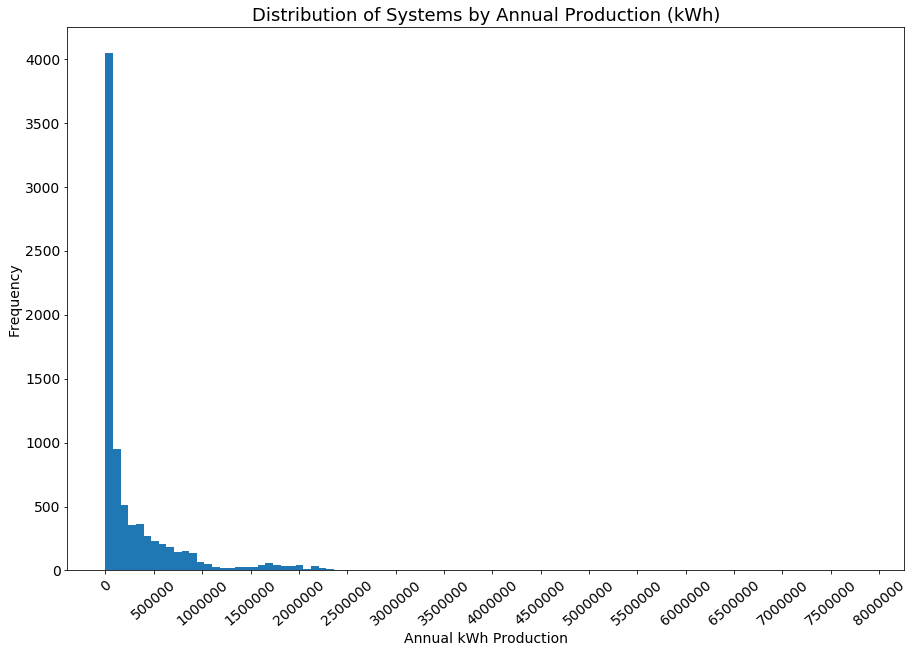

In [22]:
hist_x = df['actualkwh'].values
fig = plt.figure(figsize=(15,10))
plt.xlabel('Annual kWh Production', fontsize='14')
plt.ylabel('Frequency',fontsize='14')
plt.yticks(fontsize='14')
plt.xticks(np.linspace(0,8000000,17), fontsize='14', rotation='40')
plt.title('Distribution of Systems by Annual Production (kWh)', fontsize='18')
plt.hist(hist_x, bins=100);

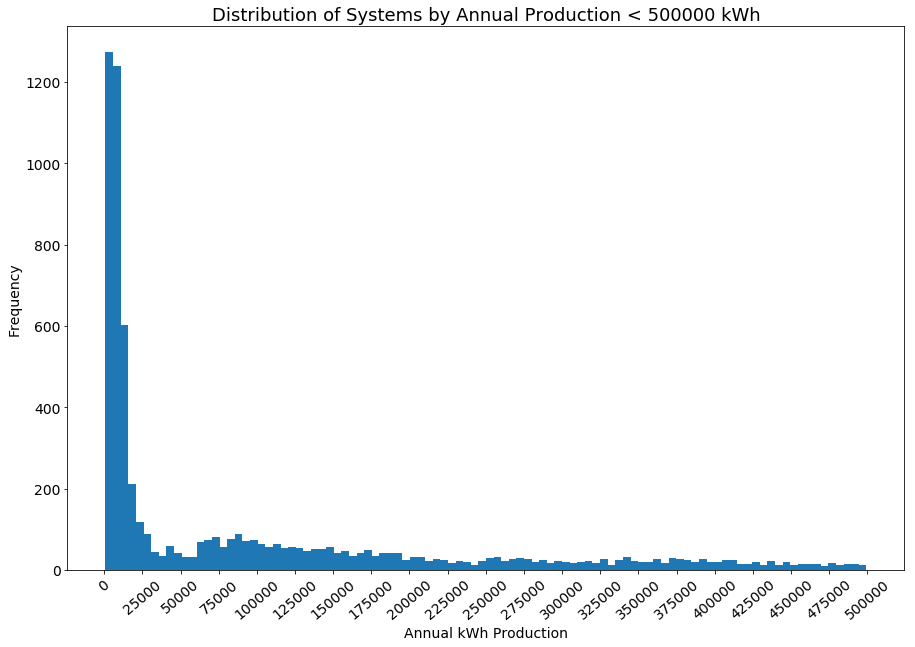

In [23]:
hist_x = df['actualkwh'][df['actualkwh']<500000].values
fig = plt.figure(figsize=(15,10))
plt.xlabel('Annual kWh Production', fontsize='14')
plt.ylabel('Frequency', fontsize='14')
plt.xticks(np.linspace(0,500000,21), fontsize='14', rotation='40')
plt.yticks(fontsize='14')
plt.title('Distribution of Systems by Annual Production < 500000 kWh', fontsize='18')
plt.hist(hist_x, bins=100);

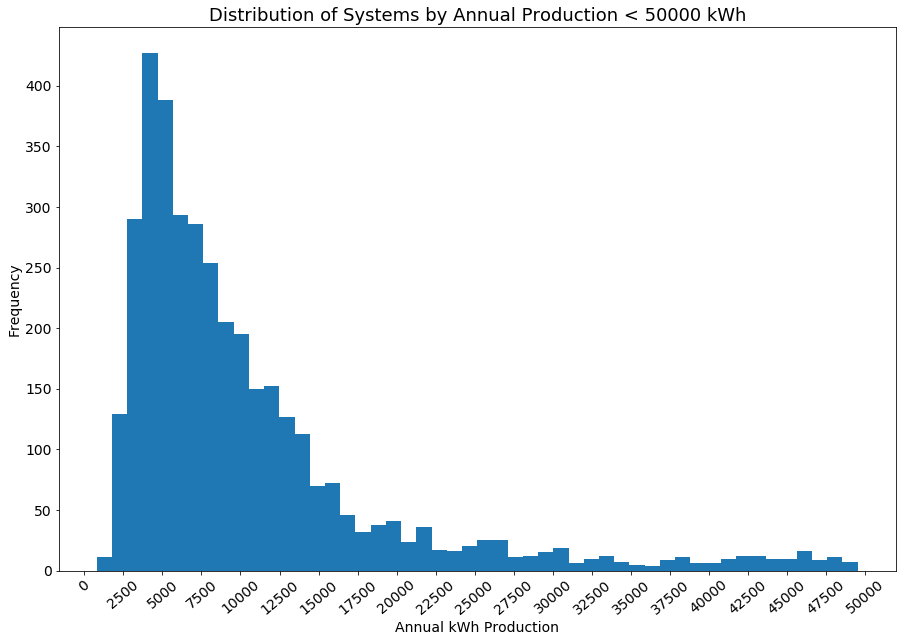

In [24]:
hist_x = df['actualkwh'][df['actualkwh']<50000].values
fig = plt.figure(figsize=(15,10))
plt.xlabel('Annual kWh Production', fontsize='14')
plt.ylabel('Frequency', fontsize='14')
plt.xticks(np.linspace(0,50000,21), fontsize='14', rotation='40')
plt.yticks(fontsize='14')
plt.title('Distribution of Systems by Annual Production < 50000 kWh', fontsize='18')
plt.hist(hist_x, bins=50);

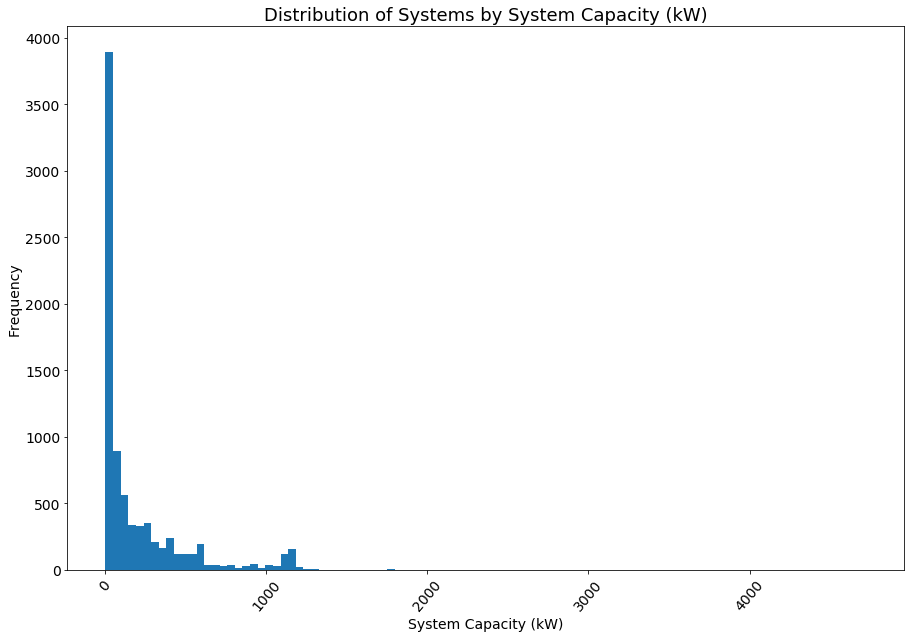

In [25]:
hist_x = df['capacity_dc_kw'].values
fig = plt.figure(figsize=(15,10))
plt.xlabel('System Capacity (kW)', fontsize='14')
plt.ylabel('Frequency', fontsize='14')
plt.yticks(fontsize='14')
plt.xticks(fontsize='14', rotation='50')
plt.title('Distribution of Systems by System Capacity (kW)', fontsize='18')
plt.hist(hist_x, bins=100);

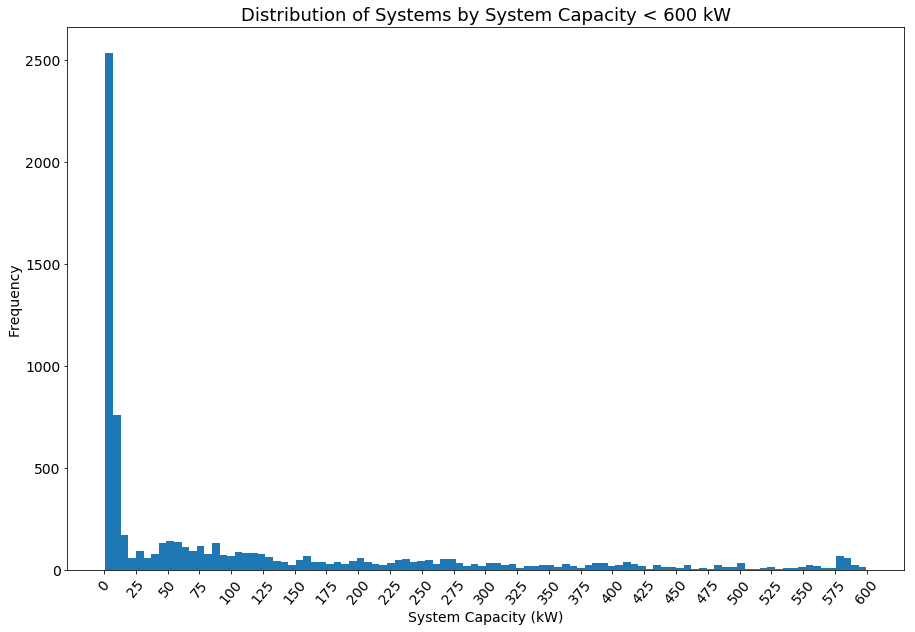

In [26]:
hist_x = df['capacity_dc_kw'][df['capacity_dc_kw']<600].values
fig = plt.figure(figsize=(15,10))
plt.xlabel('System Capacity (kW)', fontsize='14')
plt.ylabel('Frequency', fontsize='14')
plt.yticks(fontsize='14')
plt.xticks(np.linspace(0,600,25), fontsize='14', rotation='50')
plt.title('Distribution of Systems by System Capacity < 600 kW', fontsize='18')
plt.hist(hist_x, bins=100);

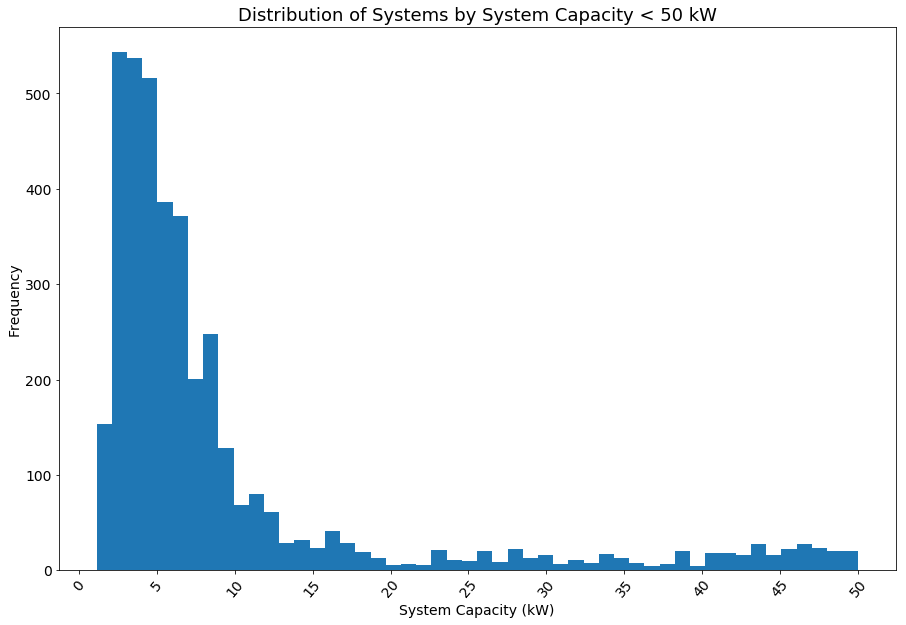

In [27]:
hist_x = df['capacity_dc_kw'][df['capacity_dc_kw']<50].values
fig = plt.figure(figsize=(15,10))
plt.xlabel('System Capacity (kW)', fontsize='14')
plt.ylabel('Frequency', fontsize='14')
plt.yticks(fontsize='14')
plt.xticks(np.linspace(0,50,11), fontsize='14', rotation='50')
plt.title('Distribution of Systems by System Capacity < 50 kW', fontsize='18')
plt.hist(hist_x, bins=50);

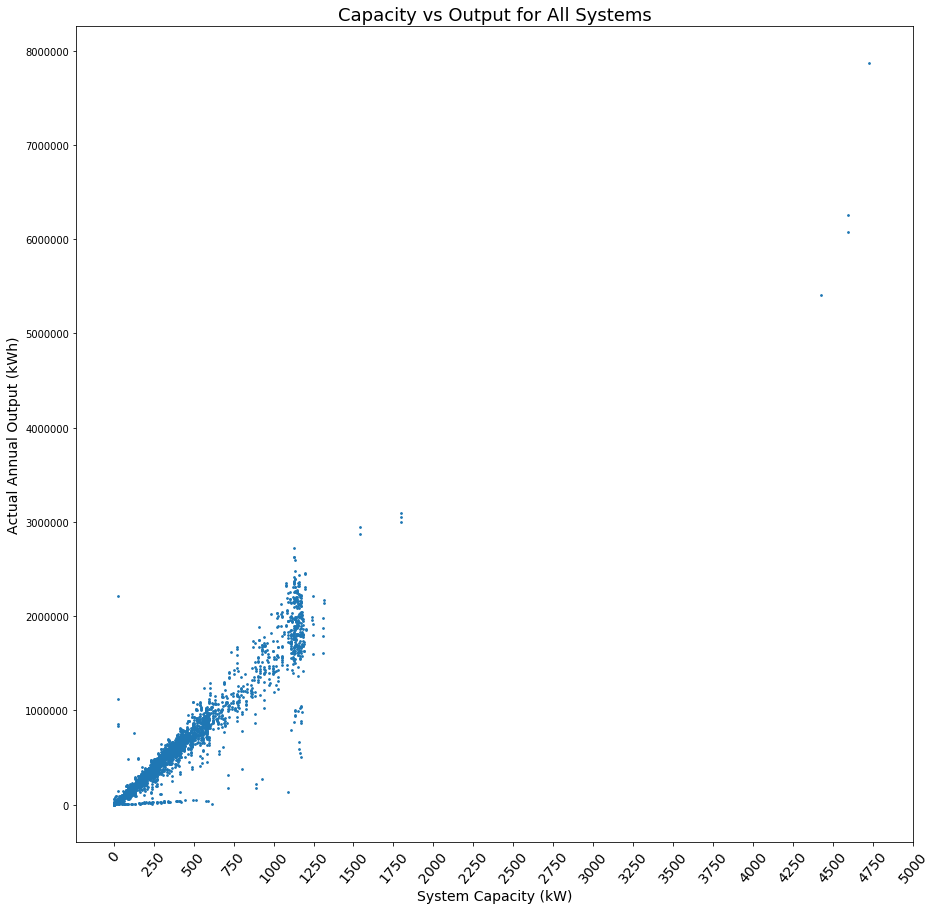

In [28]:
plt.figure(figsize=(15,15))
plt.scatter(df['capacity_dc_kw'].values, df['actualkwh'].values, s=3)
plt.title("Capacity vs Output for All Systems",fontsize='18')
# plt.yticks(np.linspace(0,900000,19))
plt.xticks(np.linspace(0,5000,21), fontsize='14', rotation='50')
plt.xlabel("System Capacity (kW)",fontsize='14')
plt.ylabel("Actual Annual Output (kWh)",fontsize='14');

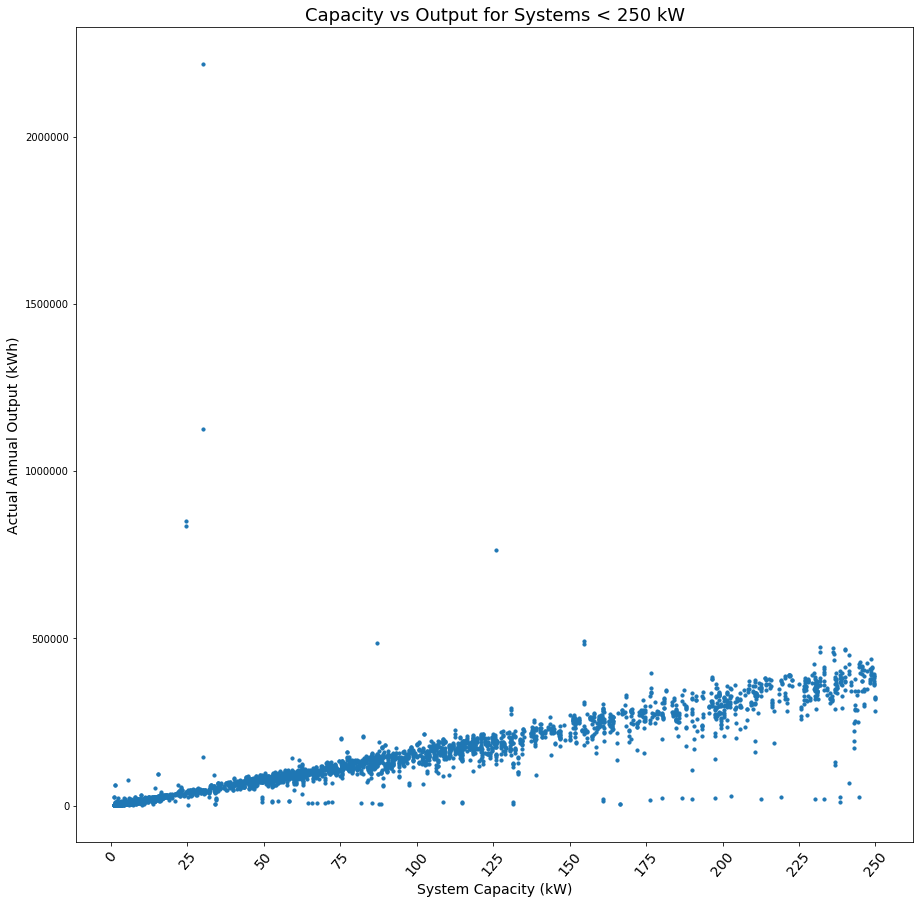

In [29]:
plt.figure(figsize=(15,15))
plt.scatter(df['capacity_dc_kw'][df['capacity_dc_kw']<250].values, df['actualkwh'][df['capacity_dc_kw']<250].values, s=10)
plt.title("Capacity vs Output for Systems < 250 kW",fontsize='18')
# plt.yticks(np.linspace(0,900000,19))
plt.xticks(np.linspace(0,250,11), fontsize='14', rotation='50')
plt.xlabel("System Capacity (kW)",fontsize='14')
plt.ylabel("Actual Annual Output (kWh)",fontsize='14');

### Looks like there are cases of over reporting production. Let's remove the outliers

In [30]:
df['efficiency'] = df['actualkwh'] / df['capacity_dc_kw']

eff_std = df.efficiency.std()
eff_mean = df.efficiency.mean()

(8146, 18)

In [ ]:
# Removing outliers > 4 std devs away from mean
efficiency_mask = np.abs((eff_mean - df['efficiency'])/eff_std) < 4

df = df.loc[efficiency_mask, :]
df.shape

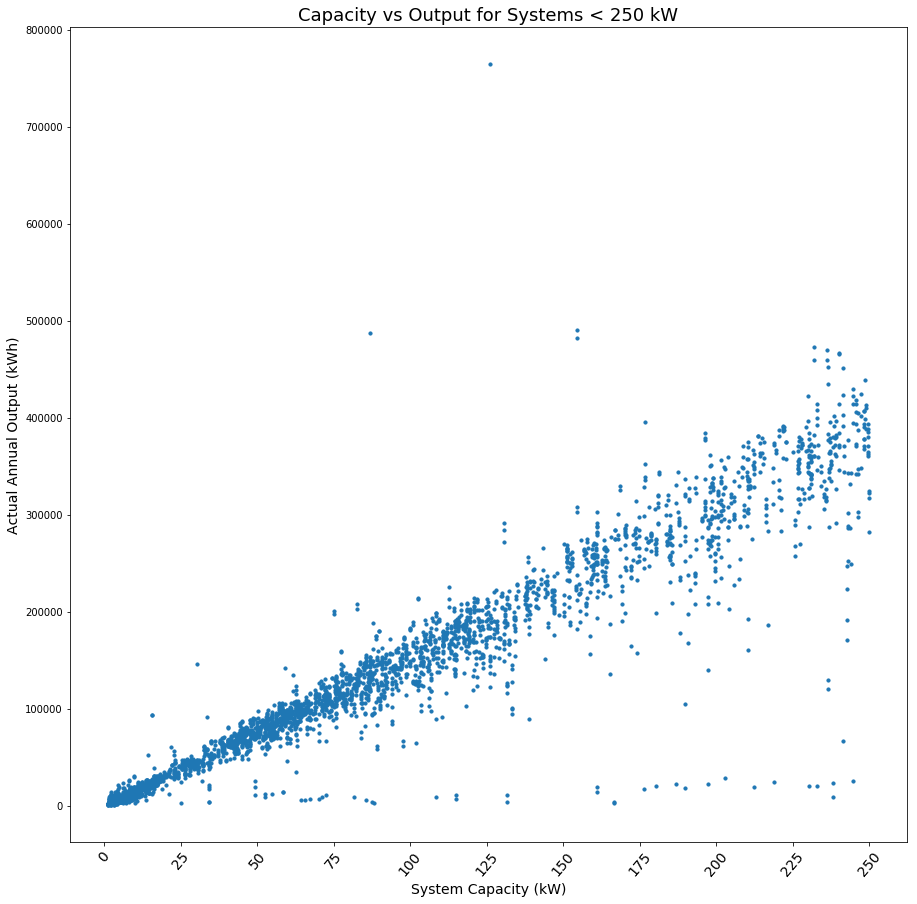

In [31]:
plt.figure(figsize=(15,15))
plt.scatter(df['capacity_dc_kw'][df['capacity_dc_kw']<250].values, df['actualkwh'][df['capacity_dc_kw']<250].values, s=10)
plt.title("Capacity vs Output for Systems < 250 kW",fontsize='18')

plt.xticks(np.linspace(0,250,11), fontsize='14', rotation='50')
plt.xlabel("System Capacity (kW)",fontsize='14')
plt.ylabel("Actual Annual Output (kWh)",fontsize='14');

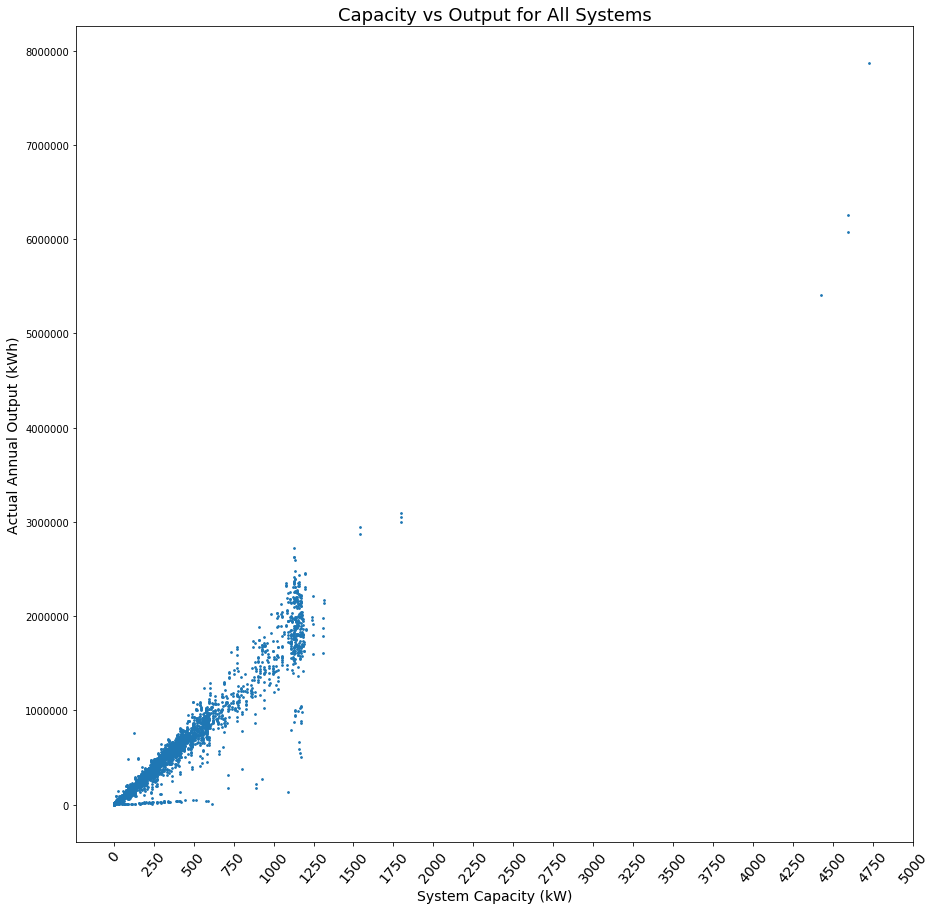

In [32]:
plt.figure(figsize=(15,15))
plt.scatter(df['capacity_dc_kw'].values, df['actualkwh'].values, s=3)
plt.title("Capacity vs Output for All Systems",fontsize='18')
# plt.yticks(np.linspace(0,900000,19))
plt.xticks(np.linspace(0,5000,21), fontsize='14', rotation='50')
plt.xlabel("System Capacity (kW)",fontsize='14')
plt.ylabel("Actual Annual Output (kWh)",fontsize='14');

In [34]:
# drop efficiency metric before we export for modeling
df.drop('efficiency', axis=1, inplace=True)

In [35]:
df.to_csv('data/df_for_modeling.csv', index=False)

# Modeling

### 1. Baseline (mean)

In [41]:
df_base = pd.read_csv('data/df_for_modeling.csv')

In [42]:
y = df_base.pop('actualkwh')

df_base['mean'] = np.mean(y)
y_mean = df_base.pop('mean')

In [43]:
X_train, X_test, y_train, y_test = train_test_split(y_mean, y, train_size=.75, test_size=.25, random_state=42)

In [44]:
base_mse = mean_squared_error(y_test, X_test)
print('Baseline rmse:',round(base_mse**.5,1))

Baseline rmse: 477643.5


### 2. Linear Regression

In [ ]:
df = df_base.copy()
y = df.pop('actualkwh')
X = df